In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

#process param
sampling_size = 20
img_width = 300
img_height = 300
process_width = 10
process_pos_range = np.random.randint(-10, 10, size=sampling_size)

all_imgs = []
for process_pos in process_pos_range:
    # create an image
    img = np.random.randint(150, 220, size=(img_width, img_height, 3), dtype=np.uint8)
    defect_qty = 0
    start_col = img_width//2 + process_pos
    # random create defect
    for side in [int(start_col - process_width//2), int(start_col + process_width//2)]:
        random_qty = np.random.randint(0, 2, size=1)[0]
        defect_pos = np.random.randint(0, 300, size=random_qty)
        defect_size = np.random.randint(3, 15, size=random_qty)
        random_color = np.random.randint(30, 50, size=(random_qty, 3))
        for pos, size, color in zip(defect_pos, defect_size, random_color):
            color = (int(color[0]), int(color[1]), int(color[2]))
            cv2.circle(img, (side, pos), size, color=(color[0], color[1], color[2]), thickness=-1)
            defect_qty += 1

    # normal process
    start_point = (start_col, 0)
    end_point = (start_col, 300)
    img = cv2.line(img, start_point, end_point, (0, 0, 0), thickness=process_width)

    if defect_qty == 0:
        label = 'good'
    else:
        label = 'bad'

    sample_img = {
        'label': label,
        'img': img
    }

    all_imgs.append(sample_img)

print(len(all_imgs))

20


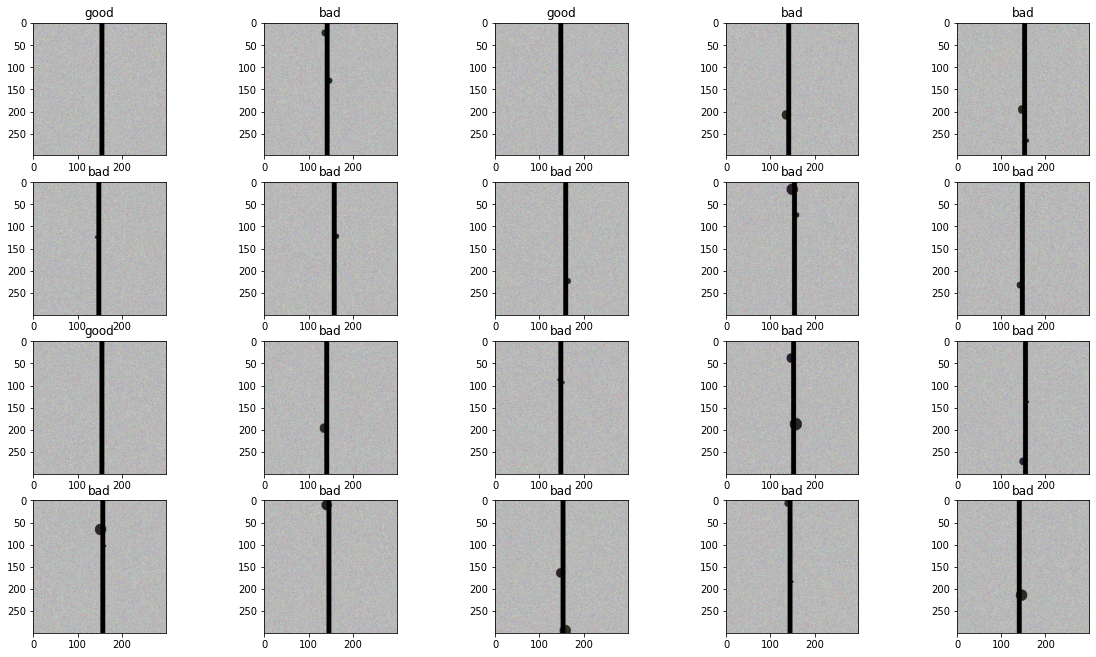

In [2]:
f = plt.figure(figsize=(20, 20))
for i in range(len(all_imgs)):
    f.add_subplot(len(all_imgs)//3 + 1, 5, i+1)
    plt.title(all_imgs[i]['label'])
    plt.imshow(all_imgs[i]['img'])

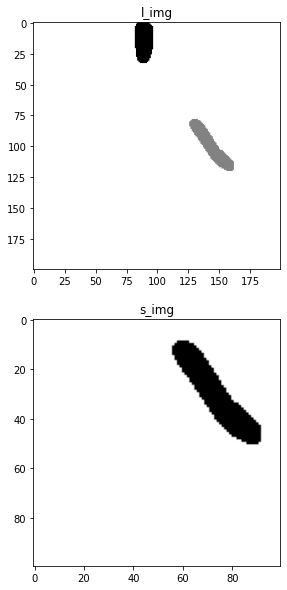

In [3]:
import numpy as np
import cv2
from scipy.special import binom
import matplotlib.pyplot as plt

bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
   N = len(points)
   t = np.linspace(0, 1, num=num)
   curve = np.zeros((num, 2))
   for i in range(N):
      curve += np.outer(bernstein(N - 1, i, t), points[i])
   return curve

class Segment():
   def __init__(self, p1, p2, angle1, angle2, **kw):
      self.p1 = p1; self.p2 = p2
      self.angle1 = angle1; self.angle2 = angle2
      self.numpoints = kw.get("numpoints", 100)
      r = kw.get("r", 0.3)
      d = np.sqrt(np.sum((self.p2-self.p1)**2))
      self.r = r*d
      self.p = np.zeros((4,2))
      self.p[0,:] = self.p1[:]
      self.p[3,:] = self.p2[:]
      self.calc_intermediate_points(self.r)

   def calc_intermediate_points(self,r):
      self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                 self.r*np.sin(self.angle1)])
      self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                 self.r*np.sin(self.angle2+np.pi)])
      self.curve = bezier(self.p,self.numpoints)

def get_curve(points, **kw):
   segments = []
   for i in range(len(points)-1):
      seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
      segments.append(seg)
   curve = np.concatenate([s.curve for s in segments])
   return segments, curve

def ccw_sort(p):
   d = p-np.mean(p,axis=0)
   s = np.arctan2(d[:,0], d[:,1])
   return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
   """ given an array of points *a*, create a curve through
   those points. 
   *rad* is a number between 0 and 1 to steer the distance of
         control points.
   *edgy* is a parameter which controls how "edgy" the curve is,
         edgy=0 is smoothest."""
   p = np.arctan(edgy)/np.pi+.5
   a = ccw_sort(a)
   a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
   d = np.diff(a, axis=0)
   ang = np.arctan2(d[:,1],d[:,0])
   f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
   ang = f(ang)
   ang1 = ang
   ang2 = np.roll(ang,1)
   ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
   ang = np.append(ang, [ang[0]])
   a = np.append(a, np.atleast_2d(ang).T, axis=1)
   s, c = get_curve(a, r=rad, method="var")
   x,y = c.T
   return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
   """ create n random points in the unit square, which are *mindst*
   apart, then scale them."""
   mindst = mindst or .7/n
   a = np.random.rand(n,2)
   d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
   if np.all(d >= mindst) or rec>=200:
      return a*scale
   else:
      return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)


def create_particle(img_size=100):
   rad = 0.2
   edgy = 0.05

   a = get_random_points(n=5, scale=1) + np.array([0, 1])
   x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
   x = [int(v*50) for v in x]
   y = [int(v*50) for v in y]

   random_curve = [[i, v] for i, v in zip(x, y)]
   arr = np.random.randint(255, 256, size=(img_size, img_size, 4), dtype=np.uint8)
   for i in range(img_size):
      for j in range(img_size):
         if [i, j] in random_curve:
            arr[i][j] = (0, 0, 0, 255)
         else:
            arr[i][j] = (255, 255, 255, 125)


   kernel = np.ones((3,3), np.uint8)
   erode = cv2.erode(arr, kernel, iterations = 1)

   erode_gray = cv2.cvtColor(erode.copy(), cv2.COLOR_BGR2GRAY)
   contours, hierarchy = cv2.findContours(erode_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
   filledContours = cv2.drawContours(erode.copy(), contours, 1, (0, 0, 0, 255), thickness=-1)

   return filledContours


s_img = create_particle(100)
l_img = create_particle(200)
x_offset = y_offset = 70
y1, y2 = y_offset, y_offset + s_img.shape[0]
x1, x2 = x_offset, x_offset + s_img.shape[1]

alpha_s = s_img[:, :, 3] / 255.0
alpha_l = 1.0 - alpha_s

for c in range(0, 3):
    l_img[y1:y2, x1:x2, c] = (alpha_s * s_img[:, :, c] +
                              alpha_l * l_img[y1:y2, x1:x2, c])


f = plt.figure(figsize=(20, 10))
f.add_subplot(2, 1, 1)
plt.title('l_img')
plt.imshow(l_img)
f.add_subplot(2, 1, 2)
plt.title('s_img')
plt.imshow(s_img)